In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!wget lane_detection_dataset.zip https://www.dropbox.com/s/a3pvo5rukig1l5s/lane_detection_dataset.zip

--2022-11-29 05:14:00--  http://lane_detection_dataset.zip/
Resolving lane_detection_dataset.zip (lane_detection_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘lane_detection_dataset.zip’
--2022-11-29 05:14:00--  https://www.dropbox.com/s/a3pvo5rukig1l5s/lane_detection_dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/a3pvo5rukig1l5s/lane_detection_dataset.zip [following]
--2022-11-29 05:14:00--  https://www.dropbox.com/s/raw/a3pvo5rukig1l5s/lane_detection_dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc99b0edcfb493d071ed39267122.dl.dropboxusercontent.com/cd/0/inline/Bxq4vWLHj1nn-OXDYXJlGpz_2peek6UpHh74BYeMct3u2LLxdBSlkT5AodZgZGzGzZxCajlVwLKHNNp_0CtoktyzogCXlw49lJaXT

In [ ]:
import os

try:
     os.makedirs('/content/LaneDetection')
except:
  pass

os.chdir('/content/LaneDetection')
try:
    os.makedirs('data')
except:
    pass

In [ ]:
!unzip -q /content/lane_detection_dataset.zip -d /content/LaneDetection/data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 100

# ImageDataGenerator를 활용해 Train, Validation, Test용 데이터 불러오기

#-- 학습데이터와 검증데이터 이미지및 정답값 데이터를 증폭하는 과정

#-- batch_size =8 -> 8장씩 랜덤하게 이미지를 추출한다.
#-- target_size = (256,512)  ->  256,512의 이미지
#-- class_mode = None -> 라벨값을 반환하지 않음

train_data_generator = ImageDataGenerator(rescale = 1.0/255.0).flow_from_directory("./data/TrainData", 
                                                                                  batch_size = 8, target_size =(256,512),seed=SEED,
                                                                                   class_mode = None)

train_label_generator = ImageDataGenerator(rescale = 1.0/255.0).flow_from_directory("./data/TrainLabel", 
                                                                                  batch_size = 8, target_size =(256,512),seed=SEED,
                                                                                   class_mode = None)

valid_data_generator = ImageDataGenerator(rescale = 1.0/255.0).flow_from_directory("./data/ValidData", 
                                                                                  batch_size = 8, target_size =(256,512),seed=SEED,
                                                                                   class_mode = None)

valid_label_generator = ImageDataGenerator(rescale = 1.0/255.0).flow_from_directory("./data/ValidLabel", 
                                                                                  batch_size = 8, target_size =(256,512),seed=SEED,
                                                                                   class_mode = None)

Found 4000 images belonging to 1 classes.
Found 4000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.


In [ ]:
from tensorflow import keras 
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, UpSampling2D, Activation, Add

#--------------------------- LaneNet을 구성하는 과정 --------------------------------------#

#-- 처음 입력이미지의 크기는 (256,512)의 크기이며 RGB 3채널이 존재하므로 input사이즈를 이미지 사이즈와 맞게(256,512,3)로 설정해준다.
input = Input(shape = (256,512,3)) 

#-- Encoder1 
enc1 = Conv2D(32, 3, padding = 'same', activation = 'relu',)(input)
enc1 = BatchNormalization()(enc1)
enc1 = Conv2D(32, 3, padding = 'same', activation = 'relu',)(enc1)
enc1 = BatchNormalization()(enc1)
enc1 = MaxPool2D(pool_size = (2,2), strides =(2,2),padding = 'same')(enc1)
enc1 = Conv2D(32, 3, padding = 'same', activation = 'relu',)(enc1)
enc1 = BatchNormalization()(enc1) #-- (128, 256, 32)

#-- (1) enc1의 첫번째 레이어는 Conv(32,3)레이어를 사용한다. 이 때 32,3의 의미는 컨볼루션 레이어에의 채널이 32개이며 window크기를 3x3으로 설정한다는 것이다.
#-- 이후 출력 이미지 사이즈가 입력 이미지 사이즈와 동일하게 하기 위해서 same padding으로 설정
#-- 활성화함수는 기울기 소실 문제 방지를 위해 max(0,x)을 반환해주는 Relu함수를 사용. 
#-- Input데이터로는 최초 input이미지를 넣어준다.
#-- (2) 모델이 local minima에 빠지않고 빠르게 학습하기 위하여 파라메터 스케일을 정규화해주는 배치정규화를 진행한다.
#-- (3) (1),(2) 과정을 한 번 더 반복한다.
#-- (4) 이미지 사이즈를 줄이기 위하여 2X2윈도우를 이용하여 가장 큰 데이터만을 가져오는 MaxPooling을 사용 보폭은 2를 사용하여 크기를 반으로 줄임
#-- (5) (1),(2) 과정을 한 번 더 반복
#-- 최종적으로  (256, 512 ,3) -----> (128,256,32) 사이즈로 변경

#-- Encoder2 
enc2 = Conv2D(64, 3, padding = 'same', activation = 'relu',)(enc1)
enc2 = BatchNormalization()(enc2)
enc2 = Conv2D(64, 3, padding = 'same', activation = 'relu',)(enc2)
enc2 = BatchNormalization()(enc2)
enc2 = MaxPool2D(pool_size = (2,2),strides =(2,2),padding = 'same')(enc2)
enc2 = Conv2D(64, 3, padding = 'same', activation = 'relu',)(enc2) #-- (64, 128, 64)

#-- (1) enc2의 첫번째 레이어는 Conv(64,3)레이어를 사용한다. 이 때 64,3의 의미는 컨볼루션 레이어에의 채널이 64개이며 window크기를 3x3으로 설정한다는 것이다.
#-- 이후 출력 이미지 사이즈가 입력 이미지 사이즈와 동일하게 하기 위해서 same padding으로 설정
#-- 활성화함수는 기울기 소실 문제 방지를 위해 max(0,x)을 반환해주는 Relu함수를 사용. 
#-- Input데이터로는 (128,256,32) 이미지 사이즈인 enc1을 넣어준다.
#-- (2) 모델이 local minima에 빠지않고 빠르게 학습하기 위하여 파라메터 스케일을 정규화해주는 배치정규화를 진행한다.
#-- (3) (1),(2) 과정을 한 번 더 반복한다.
#-- (4) 이미지 사이즈를 줄이기 위하여 2X2윈도우를 이용하여 가장 큰 데이터만을 가져오는 MaxPooling을 사용 보폭은 2를 사용하여 크기를 반으로 줄임
#-- (5) (1),(2) 과정을 한 번 더 반복
#-- 최종적으로  (128,256,32) -----> (64, 128, 64) 사이즈로 변경

#-- 레이어를 깊게 쌓을수록 좋은값이 나오지만 깊게 쌓을수록  미분값이 점점 사라지는 기울기 소실이라는 치명적인 문제 발생
#-- 이를 해결하고자 Residual Block를 사용
#-- Residual Block : 한 layer의 결과값을 바로 다음 layer에만 넣어주는 것이 아니라 좀 더 뒤에 있는 layer에도 넣어주는 것입니다. 
#-- 이러한 연결을 skip connection이라 부르며 skip connection이 있는 레이러를 Residual1 Block 이라한다.

#-- Residual1 
res1 = Conv2D(128, 3, padding = 'same', activation = 'relu',)(enc2)
res1 = BatchNormalization()(res1)
res1 = Conv2D(64, 3, padding = 'same', activation = 'relu',)(res1)
res1 = BatchNormalization()(res1)
mergeData = Add()([res1, enc2])
res1 = Activation('relu')(mergeData) #-- (64, 128, 64)

#-- (1) Residual 1번째 block을 만들기 위해 128채널의 3x3윈도우 사이즈 컨볼루션 레이러를 만들고 input으로는 이전 enc2레이어를 설정해준다.
#-- (2) 배치정규화를 사용
#-- (3) 이후 64채널 3x3윈도우 사이즈 컨볼루션 레이러를 만들고 다시 한 번 배치정규화 사용
#-- (4) Add()함수를 사용하여  Residual Block과 이전 enc2레이어를 합치고 활성화 함수로는 RELU함수를 사용

#-- Residual2
res2 = Conv2D(128, 3, padding = 'same', activation = 'relu',)(res1)
res2 = BatchNormalization()(res2)
res2 = Conv2D(64, 3, padding = 'same', activation = 'relu',)(res2)
res2 = BatchNormalization()(res2)
mergeData = Add()([res2, res1])
res2 = Activation('relu')(mergeData) #-- (64, 128, 64)

#-- (1) Residual 2번째 block을 만들기 위해 128채널의 3x3윈도우 사이즈 컨볼루션 레이러를 만들고 input으로는 이전 res1레이어를 설정해준다.
#-- (2) 배치정규화를 사용
#-- (3) 이후 64채널 3x3윈도우 사이즈 컨볼루션 레이러를 만들고 다시 한 번 배치정규화 사용
#-- (4) Add()함수를 사용하여  Residual Block과 이전 res1레이어를 합치고 활성화 함수로는 RELU함수를 사용


#-- 작게 만들었던 이미지 사이즈를 다시 업샘플링을 이용하여 원래 이미지로 만들어주는 작업이며 Encoder작업 반대

#-- Decoder1
dec1 = Conv2D(32, 3, padding = 'same', activation = 'relu',)(res2)
dec1 = BatchNormalization()(dec1)
dec1 = Conv2D(32, 3, padding = 'same', activation = 'relu',)(dec1)
dec1 = BatchNormalization()(dec1)
dec1 = UpSampling2D(size = (2,2))(dec1)
dec1 = Conv2D(32, 3, padding = 'same', activation = 'relu',)(dec1) #-- (128, 256, 32)

#-- (1) dec1의 첫번째 레이어는 Conv(32,3)레이어를 사용한다. 이 때 32,3의 의미는 컨볼루션 레이어에의 채널이 32개이며 window크기를 3x3으로 설정한다는 것이다.
#-- 이후 출력 이미지 사이즈가 입력 이미지 사이즈와 동일하게 하기 위해서 same padding으로 설정
#-- 활성화함수는 기울기 소실 문제 방지를 위해 max(0,x)을 반환해주는 Relu함수를 사용. 
#-- Input데이터로는 (64,128, 64) 이미지 사이즈인 rec2 넣어준다.
#-- (2) 모델이 local minima에 빠지않고 빠르게 학습하기 위하여 파라메터 스케일을 정규화해주는 배치정규화를 진행한다.
#-- (3) (1),(2) 과정을 한 번 더 반복한다.
#-- (4) 이미지 사이즈를 키우기 위하여  UpSampling2D (2,2)를 사용하여 2배로 증가
#-- (5) 마지막 (32,3) 컨볼루션 레이어 통과

#-- 최종적으로  (64, 128, 64) ----->  (128,256,32) 사이즈로 변경


#-- Decoder2 

dec2 = Conv2D(1, 3, padding = 'same', activation = 'relu',)(dec1)
#-- 검은색과 흰색을 표현하기 위해서 채널 수 1로 지정 --#
dec2 = BatchNormalization()(dec2)
dec2 = Conv2D(1, 3, padding = 'same', activation = 'relu',)(dec2)
dec2 = BatchNormalization()(dec2)
dec2 = UpSampling2D(size = (2,2))(dec2)
dec2 = Conv2D(1, 3, padding = 'same', activation = 'relu',)(dec2) #-- (256, 512, 1)
dec2 = BatchNormalization()(dec2)
prediction = Activation('sigmoid')(dec2)

#-- (1) dec2의 첫번째 레이어는 Conv(1,3)레이어를 사용한다. 이 때 1,3의 의미는 컨볼루션 레이어에의 채널이 1개이며 window크기를 3x3으로 설정한다는 것이다.
#-- 이 때 채널 수를 1로 지정한 이유는 검은색과 흰색만을 표현하기 위해서이다.
#-- 이후 출력 이미지 사이즈가 입력 이미지 사이즈와 동일하게 하기 위해서 same padding으로 설정
#-- 활성화함수는 기울기 소실 문제 방지를 위해 max(0,x)을 반환해주는 Relu함수를 사용. 
#-- Input데이터로는 (128,256,32) 이미지 사이즈인 dec1 넣어준다.
#-- (2) 모델이 local minima에 빠지않고 빠르게 학습하기 위하여 파라메터 스케일을 정규화해주는 배치정규화를 진행한다.
#-- (3) (1),(2) 과정을 한 번 더 반복한다.
#-- (4) 이미지 사이즈를 키우기 위하여  UpSampling2D (2,2)를 사용하여 2배로 증가
#-- (5) 마지막 (1,3) 컨볼루션 레이어 통과 이후 배치 정규화 진행
#-- 최종적으로  (128,256,32) ----->  (256, 512, 1) 사이즈로 변경
#-- 0과 1로 출력해야하므로 마지막 활성화 함수는 relu가 아닌 sigmoid를 사용해야 함 ---

# LaneNet 모델 생성
#-- input으로는 분석할 이미지데이터(3채널)를 넣어주고 output으로는 분석이 완료된 검은색과 흰색으로만 구분된 1채널 이미지가 나온다.
model = Model(inputs = input, outputs = prediction)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_65 (Conv2D)             (None, 256, 512, 32  896         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_62 (BatchN  (None, 256, 512, 32  128        ['conv2d_65[0][0]']              
 ormalization)                  )                                                           

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = Adam(learning_rate= 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

#-- optimizer는 Adam을 사용
#-- 학습률은 1e-4 사용
#-- 손실함수는 검은색과 흰색을 분류하는 문제이므로 binary_crossentropy 사용
#-- 나중에 정확도를 확인하기 위하셔 accuracy 사용

#-- 파라미터 수 계산
#-- 이전 채널 * 현재 채널 * Conv 커널 사이즈 + bias(현재 채널)

In [ ]:
batch_size = 8
steps_per_epoch = 4000//batch_size
#-- 500개
validation_batch_size = 8
validation_steps = 1000//validation_batch_size
#-- 125개

#-- batch_size는 8로 설정하여 한 번에 8개의 이미지를 학습
#-- steps_per_epoch는 한 번의 에포크 (epoch)에서 훈련에 사용할 배치 (batch)의 개수를 지정
#-- validation_steps는 한 번의 에포크가 끝날 때, 테스트에 사용되는 배치 (batch)의 개수를 지정

history = model.fit(zip(train_data_generator, train_label_generator),validation_data = zip(valid_data_generator,valid_label_generator),
              epochs = 5, batch_size = batch_size, steps_per_epoch = steps_per_epoch, validation_batch_size = validation_batch_size,
              validation_steps = validation_steps
) # batch size 실험 하기

Epoch 1/5
500/500 [==============================] - 85s 147ms/step - loss: 0.6182 - accuracy: 0.9166 - val_loss: 0.5899 - val_accuracy: 0.9301
Epoch 2/5
500/500 [==============================] - 75s 149ms/step - loss: 0.5761 - accuracy: 0.9375 - val_loss: 0.5570 - val_accuracy: 0.9425
Epoch 3/5
500/500 [==============================] - 75s 150ms/step - loss: 0.5497 - accuracy: 0.9406 - val_loss: 0.5375 - val_accuracy: 0.9421
Epoch 4/5
500/500 [==============================] - 75s 149ms/step - loss: 0.5249 - accuracy: 0.9435 - val_loss: 0.5106 - val_accuracy: 0.9448
Epoch 5/5
500/500 [==============================] - 75s 150ms/step - loss: 0.5023 - accuracy: 0.9455 - val_loss: 0.4994 - val_accuracy: 0.9416


In [ ]:
import tensorflow as tf
test_data_generator = ImageDataGenerator(rescale = 1.0/255.0).flow_from_directory("./data/TestData", 
                                                                                  batch_size = 8, target_size =(256,512),seed=SEED,
                                                                                   class_mode = None)


test_label_generator = ImageDataGenerator(rescale = 1.0/255.0).flow_from_directory("./data/TestLabel", 
                                                                                  batch_size = 8, target_size =(256,512),seed=SEED,
                                                                                   class_mode = None)



X = next(iter(test_data_generator))
Y = next(iter(test_label_generator))
Y_pred = model.predict(X)
Y_pred = tf.round(Y_pred) # Threshold = 0.5

Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 59ms/step - loss: 0.5222 - accuracy: 0.9353
Test Accuracy: 0.9353103637695312


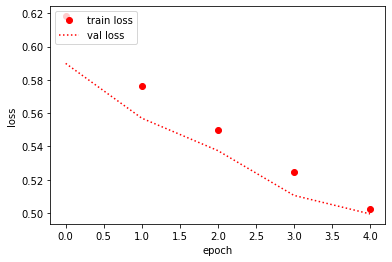

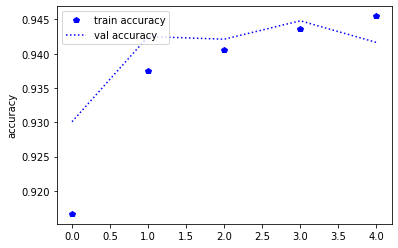

In [ ]:
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

test_loss, test_acc = model.evaluate(X, Y)

print("Test Accuracy:", test_acc)

fig, loss_ax = plt.subplots()
gix, acc_ax = plt.subplots()

loss_ax.plot(history.history['loss'], 'ro', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r:', label= 'val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'bp', label = 'train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'b:', label= 'val accuracy')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

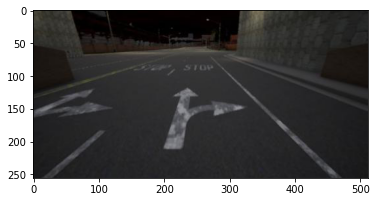

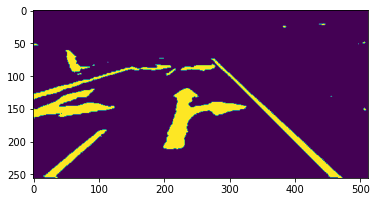

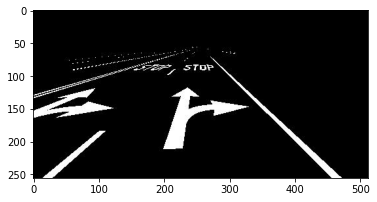

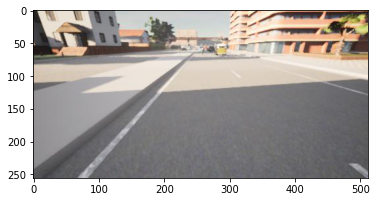

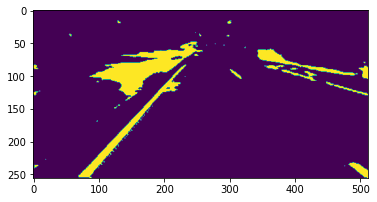

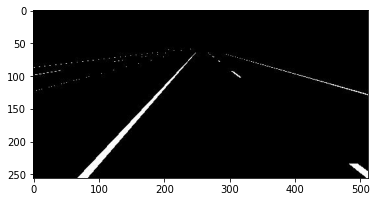

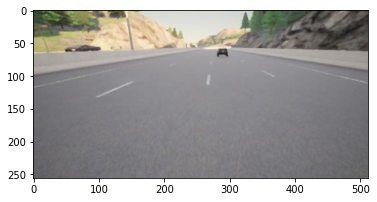

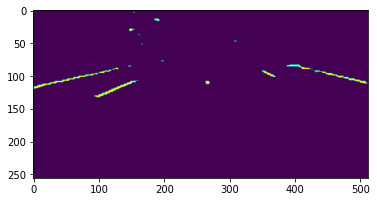

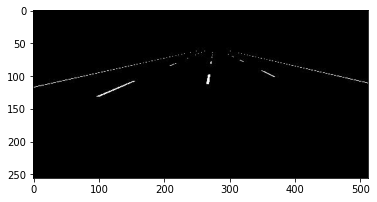

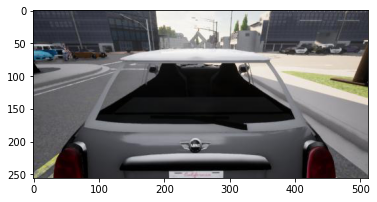

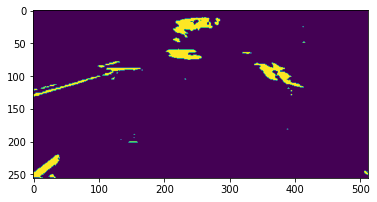

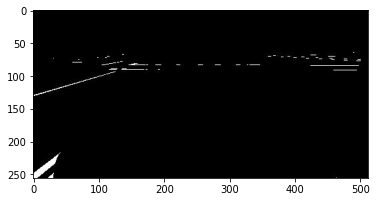

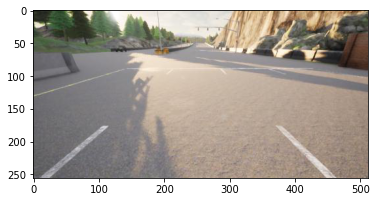

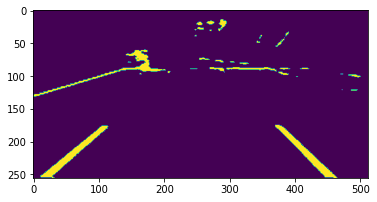

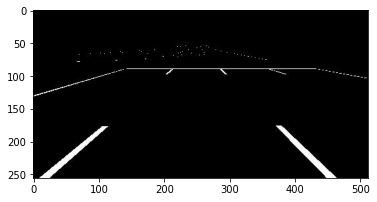

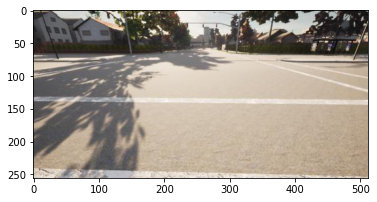

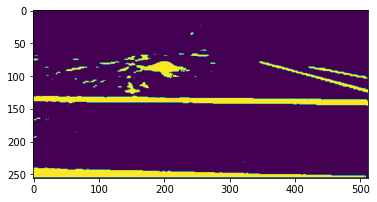

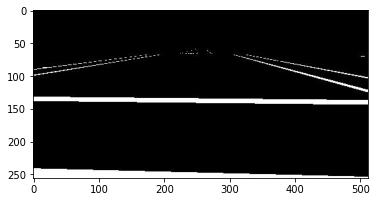

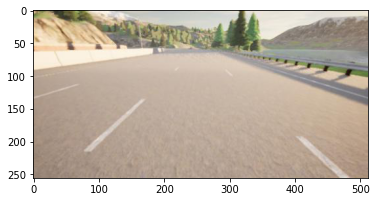

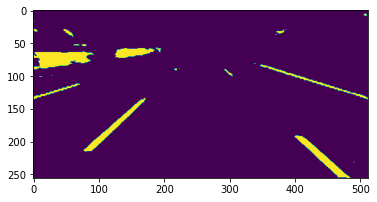

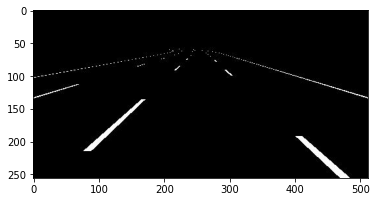

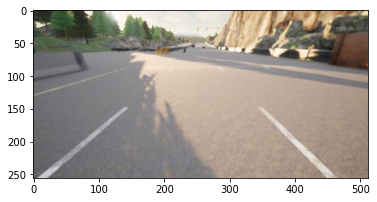

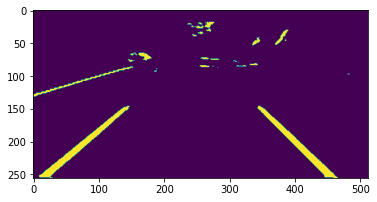

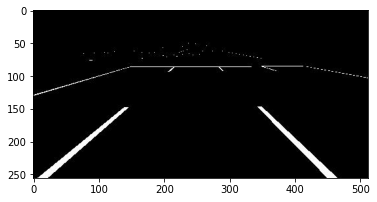

In [ ]:
import matplotlib.pyplot as plt
for i in range(8):
    plt.imshow(X[i])
    plt.show()

    plt.imshow(Y_pred[i][:,:,0])
    plt.show()

    plt.imshow(Y[i])
    plt.show()

# 첫 번째 배치결과 중 예측결과가 가장 좋은 이미지와 안 좋은 이미지에 대한 원인 분석

In [ ]:
bestImgIdx = 0

plt.imshow(X[bestImgIdx])
plt.show()

plt.imshow(Y_pred[bestImgIdx][:,:,0])
plt.show()


plt.imshow(Y[bestImgIdx])
plt.show()

#-- 가장 좋은 이미지 
#-- 이미지의 빛의 차이가 적어 차선이 일정하게 보이기 때문에 정답값과 결과값이 비슷함

NameError: ignored

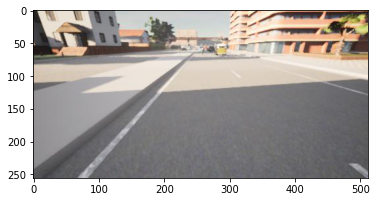

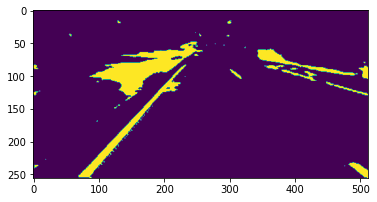

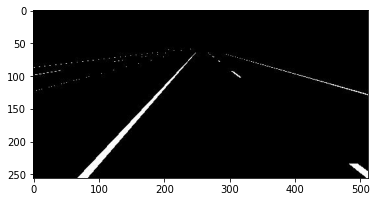

In [ ]:
worskImgIdx = 1

plt.imshow(X[worskImgIdx])
plt.show()

plt.imshow(Y_pred[worskImgIdx][:,:,0])
plt.show()

plt.imshow(Y[worskImgIdx])
plt.show()
#-- 가장 안 좋은 이미지 
#-- input이미지가 그림자 변화가 생기는 구간을 차선으로 오인하는 경우 발생

## 모델 개선

In [ ]:
from pyparsing import actions
from tensorflow import keras 
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, UpSampling2D, Activation, Add,Dropout

#--------------------------- U-NET  --------------------------------------#

#-- 처음 입력이미지의 크기는 (256,512)의 크기이며 RGB 3채널이 존재하므로 input사이즈를 이미지 사이즈와 맞게(256,512,3)로 설정해준다.
input = Input(shape = (256,512,3)) 

#-- Encoder1 

enc1 = Conv2D(64, 3, padding = 'same', activation = 'relu',kernel_initializer = 'he_normal')(input)
enc1 = BatchNormalization()(enc1)
enc1 = Dropout(0.1) (enc1)
enc1 = Conv2D(64, 3, padding = 'same', activation = 'relu',kernel_initializer = 'he_normal')(enc1)
enc1 = BatchNormalization()(enc1)
enc1Pool = MaxPool2D(pool_size = (2,2))(enc1)

#-- U-Net 구조의 첫 번째 Encoder레이어이며 2개의 Conv2D레이어를 통과한 후 Maxpooling을 사용하여 사이즈를 반으로 줄였다.
#-- 이 때 Overfitting 을 방지하기 위해 드롭아웃을 사용하여 파라메터 수를 조절하였다.
#-- 이 후 현재 레이어에 대한 정보를 Decoder레이어에 전달해줘야 하므로 따로 저장하였다.
#-- (256,512,3) -->  (128,256,64) 이미지 사이지로 다운샘플링

#-- Encorder2
enc2 = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(enc1Pool)
enc2 = BatchNormalization()(enc2)
enc2 = Dropout(0.1) (enc2)
enc2 = Conv2D(128, 3, padding = 'same', activation = 'relu',kernel_initializer = 'he_normal')(enc2)
enc2 = BatchNormalization()(enc2)
enc2Pool = MaxPool2D(pool_size = (2,2))(enc2)

#-- U-Net 구조의 두 번째 Encoder레이어이며 첫 번째 레이어와 마찬가지로 2개의 Conv2D레이어를 통과한 후 Maxpooling을 사용하여 사이즈를 반으로 줄였다.
#-  이 때 Overfitting 을 방지하기 위해 드롭아웃을 사용하여 파라메터 수를 조절하였다.
#-- 이 후 현재 레이어에 대한 정보를 Decoder레이어에 전달해줘야 하므로 따로 저장하였다.
#-- (128,256,64)  --> (64,128,128)    이미지 사이지로 다운샘플링

#-- Encorder3
enc3= Conv2D(256, 3, padding = 'same', activation = 'relu',kernel_initializer = 'he_normal')(enc2Pool)
enc3 = BatchNormalization()(enc3)
enc3 = Dropout(0.1) (enc3)
enc3 = Conv2D(256, 3, padding = 'same', activation = 'relu',kernel_initializer = 'he_normal')(enc3)
enc3 = BatchNormalization()(enc3)
enc3Pool = MaxPool2D(pool_size = (2,2))(enc3)

#-- U-Net 구조의 세 번째 Encoder레이어이며 이전 레이어와 마찬가지로 2개의 Conv2D레이어를 통과한 후 Maxpooling을 사용하여 사이즈를 반으로 줄였다.
#-  이 때 Overfitting 을 방지하기 위해 드롭아웃을 사용하여 파라메터 수를 조절하였다.
#-- 이 후 현재 레이어에 대한 정보를 Decoder레이어에 전달해줘야 하므로 따로 저장하였다.
#-- (64,128,128)  --> (32, 64, 256)   이미지 사이지로 다운샘플링

#-- Encoder4
enc4 = Conv2D(512, 3, padding = 'same', activation = 'relu',kernel_initializer = 'he_normal')(enc3Pool)
enc4 = BatchNormalization()(enc4)
enc4 = Dropout(0.2)(enc4)
enc4 = Conv2D(512, 3, padding = 'same', activation = 'relu',kernel_initializer = 'he_normal')(enc4)
enc4 = BatchNormalization()(enc4)
enc4Pool = MaxPool2D(pool_size = (2,2))(enc4)

#-- U-Net 구조의 마지막 Encoder레이어이며 이전 레이어와 마찬가지로 2개의 Conv2D레이어를 통과한 후 Maxpooling을 사용하여 사이즈를 반으로 줄였다.
#-  이 때 Overfitting 을 방지하기 위해 드롭아웃을 사용하여 파라메터 수를 조절하였다.
#-- 이 후 현재 레이어에 대한 정보를 Decoder레이어에 전달해줘야 하므로 따로 저장하였다.
#-- (32, 64, 256) --> (16,32,512) 이미지 사이지로 다운샘플링

#-- Bridge
bridge = Conv2D(1024, 3, padding = 'same', activation = 'relu',kernel_initializer = 'he_normal')(enc4Pool)
bridge = BatchNormalization()(bridge)
bridge = Dropout(0.3)(bridge)
bridge = Conv2D(1024, 3, padding = 'same', activation = 'relu',kernel_initializer = 'he_normal')(bridge)
bridge = BatchNormalization()(bridge)

#-- Bottleneck 구간이며 Encoder 단계 이후 Decoder단계를 이어주는 다리와 같은 역할이다.
#-- 2개의 Conv2D 레이어를 통과
#-- Overfittingd을 방지하기 위하여 Dropout사용
#-- (16,32,512) --> (16,32,1024)

#-- Decoder1
dec1 = tf.keras.layers.Conv2DTranspose(512, 2, strides=(2,2), padding = 'same')(bridge)
dec1 = tf.keras.layers.Concatenate()([dec1, enc4])
dec1 = Conv2D(512, 3, padding = 'same', activation = 'relu',kernel_initializer = 'he_normal')(dec1)
dec1 = BatchNormalization()(dec1)
dec1 = Dropout(0.2)(dec1)
dec1 = Conv2D(512, 3, padding = 'same', activation = 'relu',kernel_initializer = 'he_normal')(dec1)
dec1 = BatchNormalization()(dec1)

#-- U-Net 구조의 첫 번째 Decoder 레이어이며  Conv2DTranspose를 사용하여 이미지를 업샘플링 과정을 거친다.
#-  이 후 현재 레이어와 같은 단계의 Feature Map을 합쳐 준다.
#-- Conv2D 레이어를 두 번 통과
#-- Overfitting 을 방지하기 위해 드롭아웃을 사용하여 파라메터 수를 조절하였다.
#-- (16,32,1024) --> (32, 64, 512)  이미지 사이지로 업샘플링


#-- Decoder2 
dec2 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2,2), padding = 'same')(dec1)
dec2 = tf.keras.layers.Concatenate()([dec2, enc3])
dec2 = Conv2D(256, 3, padding = 'same', activation = 'relu',kernel_initializer = 'he_normal')(dec2)
dec2 = BatchNormalization()(dec2)
dec1 = Dropout(0.2)(dec1)
dec2 = Conv2D(256, 3, padding = 'same', activation = 'relu',kernel_initializer = 'he_normal')(dec2)
dec2 = BatchNormalization()(dec2)


#-- U-Net 구조의 두 번째 Decoder 레이어이며 첫 번째 레이어와 마찬가지로 Conv2DTranspose를 사용하여 이미지를 업샘플링 과정을 거친다.
#-  이 후 현재 레이어와 같은 단계의 Feature Map을 합쳐 준다.
#-- Conv2D 레이어를 두 번 통과
#-- Overfitting 을 방지하기 위해 드롭아웃을 사용하여 파라메터 수를 조절하였다.
#-- (32, 64, 512) --> (64,128,256)  이미지 사이지로 업샘플링


#-- Decoder3
dec3 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2,2), padding = 'same')(dec2)
dec3 = tf.keras.layers.Concatenate()([dec3, enc2])
dec3 = Conv2D(128, 3, padding = 'same', activation = 'relu',kernel_initializer = 'he_normal')(dec3)
dec3 = BatchNormalization()(dec3)
dec1 = Dropout(0.1)(dec1)
dec3 = Conv2D(128, 3, padding = 'same', activation = 'relu',kernel_initializer = 'he_normal')(dec3)
dec3 = BatchNormalization()(dec3)

#-- U-Net 구조의 세 번째 Decoder 레이어이며 이전 레이어와 마찬가지로 Conv2DTranspose를 사용하여 이미지를 업샘플링 과정을 거친다.
#-  이 후 현재 레이어와 같은 단계의 Feature Map을 합쳐 준다.
#-- Conv2D 레이어를 두 번 통과
#-- Overfitting 을 방지하기 위해 드롭아웃을 사용하여 파라메터 수를 조절하였다.
#--  (64,128,256) --> (128,256,128) 이미지 사이지로 업샘플링

#-- Decoder4
dec4 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2,2), padding = 'same')(dec3)
dec4 = tf.keras.layers.Concatenate()([dec4, enc1])
dec4 = Conv2D(64, 3, padding = 'same', activation = 'relu',kernel_initializer = 'he_normal')(dec4)
dec4 = BatchNormalization()(dec4)
dec1 = Dropout(0.1)(dec1)
dec4 = Conv2D(64, 3, padding = 'same', activation = 'relu',kernel_initializer = 'he_normal')(dec4)
dec4 = BatchNormalization()(dec4)

#-- U-Net 구조의 마지막 Decoder 레이어이며 이전 레이어와 마찬가지로 Conv2DTranspose를 사용하여 이미지를 업샘플링 과정을 거친다.
#-  이 후 현재 레이어와 같은 단계의 Feature Map을 합쳐 준다.
#-- Conv2D 레이어를 두 번 통과
#-- Overfitting 을 방지하기 위해 드롭아웃을 사용하여 파라메터 수를 조절하였다.
#-- (128,256,128) --> (256, 512, 64) 이미지 사이지로 업샘플링

prediction = Conv2D(1,1, padding = 'same', activation = 'sigmoid',kernel_initializer = 'he_normal')(dec4)
#-- 마지막 out이며 흑과백으로 분류된 이미지를 출력해야 하므로 1채널 컨볼루션 레이어와 sigmoid 활성함수를 사용
#-- (256, 512, 1) 최종 output 크기

model = Model(inputs = input, outputs = prediction)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_81 (Conv2D)             (None, 256, 512, 64  1792        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_76 (BatchN  (None, 256, 512, 64  256        ['conv2d_81[0][0]']              
 ormalization)                  )                                                           

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = Adam(learning_rate= 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
batch_size = 8
steps_per_epoch = 4000//batch_size
#-- 500개
validation_batch_size = 8
validation_steps = 1000//validation_batch_size
#-- 125개

history = model.fit(zip(train_data_generator, train_label_generator),validation_data = zip(valid_data_generator,valid_label_generator),
              epochs = 10, batch_size = batch_size, steps_per_epoch = steps_per_epoch, validation_batch_size = validation_batch_size,
              validation_steps = validation_steps
) # batch size 실험 하기

Epoch 1/10
500/500 [==============================] - 568s 1s/step - loss: 0.4134 - accuracy: 0.8977 - val_loss: 0.2188 - val_accuracy: 0.9431
Epoch 2/10
500/500 [==============================] - 546s 1s/step - loss: 0.1829 - accuracy: 0.9498 - val_loss: 0.1189 - val_accuracy: 0.9483
Epoch 3/10
500/500 [==============================] - 546s 1s/step - loss: 0.0981 - accuracy: 0.9506 - val_loss: 0.0711 - val_accuracy: 0.9499
Epoch 4/10
500/500 [==============================] - 545s 1s/step - loss: 0.0672 - accuracy: 0.9506 - val_loss: 0.0504 - val_accuracy: 0.9504
Epoch 5/10
500/500 [==============================] - 546s 1s/step - loss: 0.0469 - accuracy: 0.9514 - val_loss: 0.0377 - val_accuracy: 0.9514
Epoch 6/10
500/500 [==============================] - 546s 1s/step - loss: 0.0374 - accuracy: 0.9516 - val_loss: 0.0315 - val_accuracy: 0.9511
Epoch 7/10
500/500 [==============================] - 545s 1s/step - loss: 0.0307 - accuracy: 0.9517 - val_loss: 0.0270 - val_accuracy: 0.9518

In [ ]:
import tensorflow as tf
test_data_generator = ImageDataGenerator(rescale = 1.0/255.0).flow_from_directory("./data/TestData", 
                                                                                  batch_size = 8, target_size =(256,512),seed=SEED,
                                                                                   class_mode = None)


test_label_generator = ImageDataGenerator(rescale = 1.0/255.0).flow_from_directory("./data/TestLabel", 
                                                                                  batch_size = 8, target_size =(256,512),seed=SEED,
                                                                                   class_mode = None)



X = next(iter(test_data_generator))
Y = next(iter(test_label_generator))
Y_pred = model.predict(X)
Y_pred = tf.round(Y_pred) # Threshold = 0.5

Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
1/1 [==============================] - 0s 346ms/step


1/1 [==============================] - 0s 386ms/step - loss: 0.0175 - accuracy: 0.9538
Test Accuracy: 0.9537973403930664


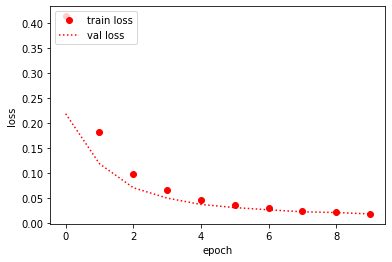

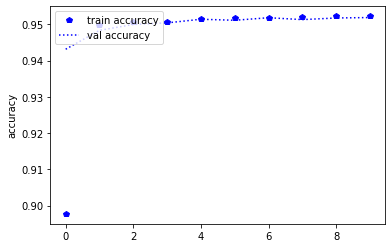

In [ ]:
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

test_loss, test_acc = model.evaluate(X, Y)

print("Test Accuracy:", test_acc)

fig, loss_ax = plt.subplots()
gix, acc_ax = plt.subplots()

loss_ax.plot(history.history['loss'], 'ro', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r:', label= 'val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'bp', label = 'train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'b:', label= 'val accuracy')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

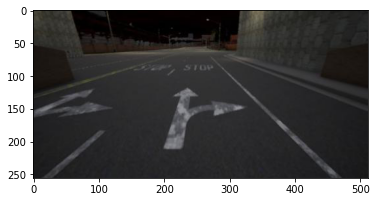

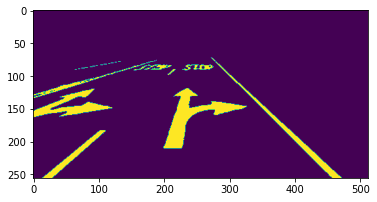

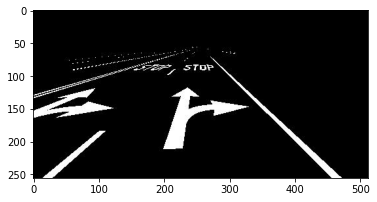

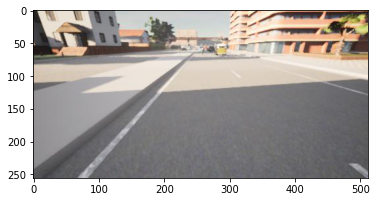

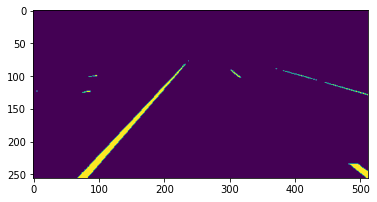

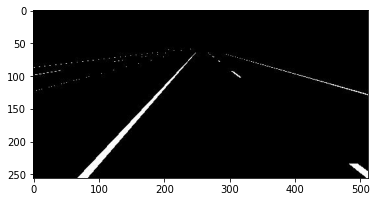

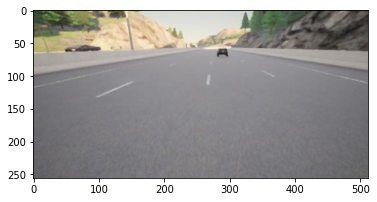

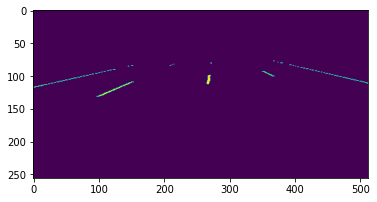

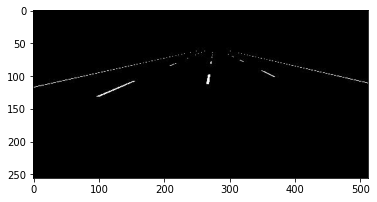

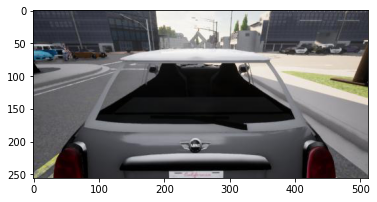

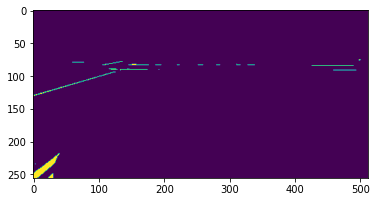

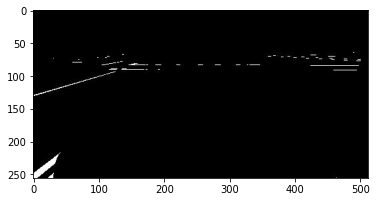

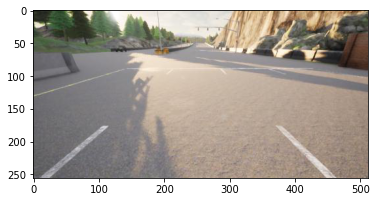

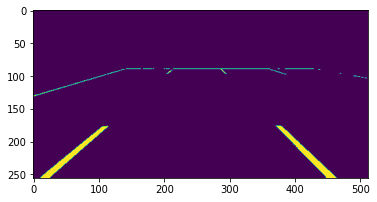

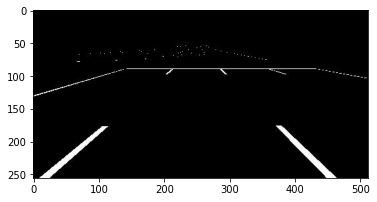

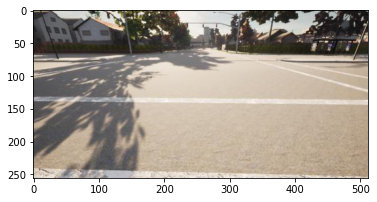

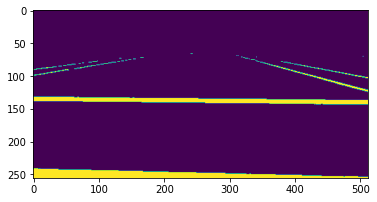

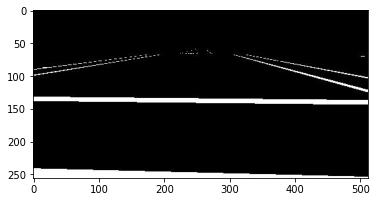

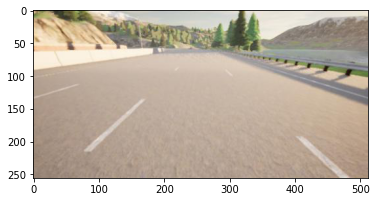

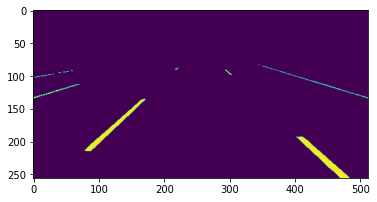

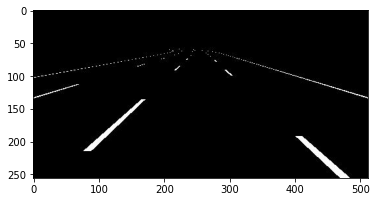

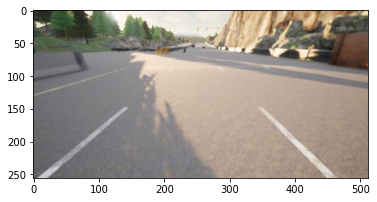

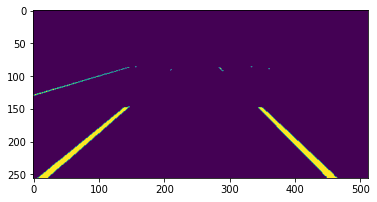

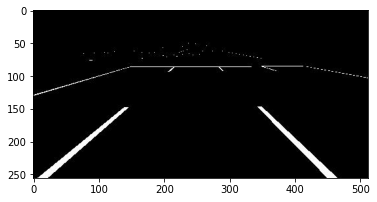

In [ ]:
import matplotlib.pyplot as plt
for i in range(8):
    plt.imshow(X[i])
    plt.show()

    plt.imshow(Y_pred[i][:,:,0])
    plt.show()

    plt.imshow(Y[i])
    plt.show()

### 가장 좋은 이미지와 안 좋은 이미지 분석

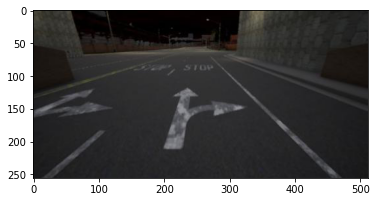

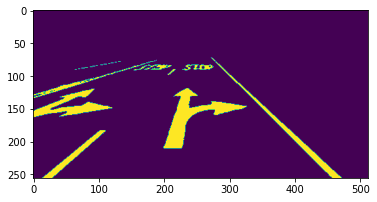

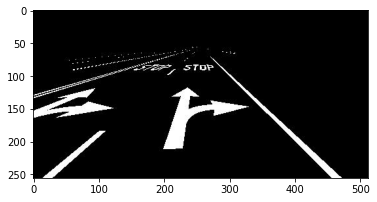

In [ ]:
bestImgIdx = 0

plt.imshow(X[bestImgIdx])
plt.show()

plt.imshow(Y_pred[bestImgIdx][:,:,0])
plt.show()


plt.imshow(Y[bestImgIdx])
plt.show()

#-- 가장 좋은 이미지 
#-- 기존 모델과 마찬가지로 이미지의 그림자가 적고 차선이 잘 보이기 때문에 개선된 모델로도 정답값과 결과값이 매우 비슷함

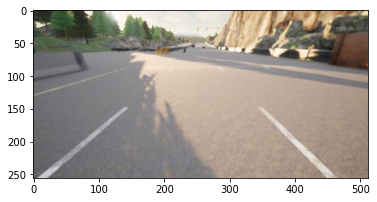

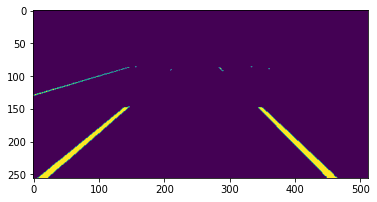

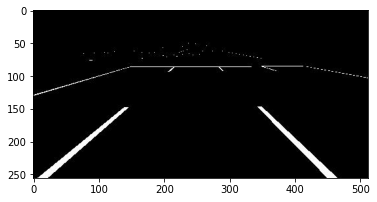

In [ ]:
worskImgIdx = 7

plt.imshow(X[worskImgIdx])
plt.show()

plt.imshow(Y_pred[worskImgIdx][:,:,0])
plt.show()

plt.imshow(Y[worskImgIdx])
plt.show()

#-- 가장 안 좋은 이미지
#-- input 이미지가 먼 거리 + 그림자까지 발생하니 차선을 거의 인식하지 못함

## U-Net은 크게 'Contracting path', 'Bottle Neck', 'Expanding path'로 구성되어있다.

### 1. 첫 번째로는 수축 단계(Contracting path)이며 다음과 같은 연산을 반복한다.
- Conv2D(3X3 , padding = 'same', activation = 'relu',kernel_initializer = 'he_normal')  X 2
- BatchNormalization()
- Dropout(0.1)
- Max Pooling( 2x2 kernel, stride : 2) 
  - 다운샘플링

### 2. 두 번째로는 전환 구간(Bottle neck)구간이며 수축 단계를 거친 후 팽창 단계로 전환되는 구간이다.
Convolution( 3x3 kernel, stride : 1) X 2
BatchNormalization()

### 3. 마지막으로는 팽창 단계((Expanding path)이다. 팽창 단계는  Up-Convolution( 2x2 kernel, stride : 2) 이후 같은 단계에 있는 Feature map을 합치는 단계이다.
- Conv2DTranspose
  - 업샘플링 단계
- Concatenate([현재레이어, 같은단계 레이어)
  - 현재 레이어와 같은단계 레이어를 합치는 단계
- Convolution( 3x3 kernel, stride : 1) X 2
- Dropout(0.1)
- BatchNormalization()


Feature map이 작아지면서 이미지 정보등이 사라질 수 있는데 U-Net 구조에서 이전 단계에 있던 Feature map을 Decoder하는 레이어에 인풋으로 넣어줌으로 이미지 손실을 방지하여 예측이미지가 상당히 좋아졌다는걸 확인해볼 수 있었다. 또한 이전 모델과 비교하면 약간의 정확도 상승을 확인할 수 있었다. 수치뿐 아니라 실제 베스트 이미지와 워스트 이미지 또한 확연하게 달라졌다는걸 확인해볼 수 있었다.

